In [112]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


In [113]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")

In [114]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

In [115]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applica l'undersampling solo al set di training
rus = RandomUnderSampler(sampling_strategy=0.03)  # mantiene una proporzione di 1:4 tra le classi minoritarie e maggioritarie
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


LightGBM : Tuning hyperparametri

In [162]:

def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    rus = RandomUnderSampler(sampling_strategy=0.03, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)  # Reset index here
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)
    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 2**trial.suggest_int('max_depth', 5, 15)),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'random_state': 42,
        'force_col_wise': True,
        'verbosity': -1
    }
# CV : ogni fold è usato 1 volta per la validation e 9 per il training, in questo modo riduciamo la varianza al minimo
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)


sampler = optuna.samplers.TPESampler(seed=42)  

study = optuna.create_study(direction='maximize', sampler = sampler)

study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()


[I 2024-04-18 23:18:44,026] A new study created in memory with name: no-name-0826bac6-d2e7-4346-97ba-f9dc5bea78b8
[I 2024-04-18 23:19:06,731] Trial 0 finished with value: 0.9899586767618015 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 4912, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.9899586767618015.
[I 2024-04-18 23:19:19,901] Trial 1 finished with value: 0.9906087679304664 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 39, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.9906087679304664.
[I 2024-04-

Best Hyperparameters: {'n_estimators': 195, 'learning_rate': 0.0689356536665432, 'max_depth': 13, 'num_leaves': 1946, 'min_child_samples': 37, 'subsample': 0.8841796423370363, 'subsample_freq': 0, 'colsample_bytree': 0.783386192594209, 'reg_alpha': 0.7592044537020304, 'reg_lambda': 0.538402350448647, 'max_bin': 269}
Best ROC AUC Score: 0.9918504426589758


In [167]:
'''
Best Hyperparameters: {'n_estimators': 195, 'learning_rate': 0.0689356536665432, 'max_depth': 13, 'num_leaves': 1946, 'min_child_samples': 37, 'subsample': 0.8841796423370363, 'subsample_freq': 0, 'colsample_bytree': 0.783386192594209, 'reg_alpha': 0.7592044537020304, 'reg_lambda': 0.538402350448647, 'max_bin': 269}
Best ROC AUC Score: 0.9918504426589758
'''
best_params = {
    'n_estimators': 195,
    'learning_rate': 0.0689356536665432,
    'max_depth': 13,
    'num_leaves': 1946,
    'min_child_samples': 37,
    'subsample': 0.8841796423370363,
    'subsample_freq': 0,
    'colsample_bytree': 0.783386192594209,
    'reg_alpha': 0.7592044537020304,
    'reg_lambda': 0.538402350448647,
    'max_bin': 269,
    'random_state': 42,
    'force_col_wise': True,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_res, y_train_res)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [120]:
best_lgb_classifier

LGBMClassifier(colsample_bytree=0.6518355641936273, force_col_wise=True,
               learning_rate=0.045336423535558106, max_bin=280, max_depth=8,
               min_child_samples=50, n_estimators=264, num_leaves=72,
               random_state=42, reg_alpha=0.6759647727667966,
               reg_lambda=0.9300125049175274, subsample=0.9563930027208176,
               subsample_freq=1, verbosity=-1)

XGBoost: Tuning hyperparametri

In [121]:
'''
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.1, 1.0)
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)

    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train, eval_metric="auc")
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()
'''

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.5),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 

In [122]:
'''
Best Hyperparameters: {'sampling_strategy': 0.1251773261463979, 'n_estimators': 911, 'learning_rate': 0.05255473835317336, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6405856996548562, 'colsample_bytree': 0.9964394946899515, 'gamma': 1.2121534098151838, 'reg_alpha': 1.1808576291047457, 'reg_lambda': 2.7143652609430546}
Best ROC AUC Score: 0.9910838203489621
'''
# Define the hyperparameters for the XGBoost classifier, taken from the best hyperparameters provided
xgb_params = {
    'n_estimators': 911,
    'learning_rate': 0.05255473835317336,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.6405856996548562,
    'colsample_bytree': 0.9964394946899515,
    'gamma': 1.2121534098151838,
    'reg_alpha': 1.1808576291047457,
    'reg_lambda': 2.7143652609430546,
    'random_state': 42  
}

# Create the XGBoost classifier instance with the best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(**xgb_params)

best_xgb_classifier.fit(X_train_res, y_train_res)
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]

In [123]:
best_xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9964394946899515, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2121534098151838,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05255473835317336,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=911, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Catboost: Tuning hyperparametri

In [124]:
'''
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.1, 1.0)
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)

    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'random_state': 42,
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()
'''

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 300),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.2, log=True),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 15),\n        \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 1e-3, 1

In [125]:
'''
Best Hyperparameters: {'sampling_strategy': 0.24371396656270275, 'n_estimators': 233, 'learning_rate': 0.1475404432012003, 'max_depth': 10, 'l2_leaf_reg': 1.66818163795537, 'border_count': 234, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Newton'}
Best ROC AUC Score: 0.991390354317063
'''
catboost_params = {
    'n_estimators': 233,
    'learning_rate': 0.1475404432012003,
    'max_depth': 10,
    'l2_leaf_reg': 1.66818163795537,
    'border_count': 234,
    'grow_policy': 'Depthwise',
    'min_data_in_leaf': 40,
    'leaf_estimation_iterations': 2,
    'leaf_estimation_method': 'Newton',
    'random_state': 42  # Assuming we keep the random state consistent with the other models
}

# Create the CatBoost classifier instance with the best hyperparameters
best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train_res, y_train_res)
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]


0:	learn: 0.5362762	total: 22ms	remaining: 5.11s
1:	learn: 0.4276353	total: 49.8ms	remaining: 5.75s
2:	learn: 0.3474700	total: 72.1ms	remaining: 5.53s
3:	learn: 0.2886070	total: 92.4ms	remaining: 5.29s
4:	learn: 0.2425004	total: 115ms	remaining: 5.24s
5:	learn: 0.2105585	total: 139ms	remaining: 5.26s
6:	learn: 0.1841922	total: 163ms	remaining: 5.27s
7:	learn: 0.1677869	total: 185ms	remaining: 5.21s
8:	learn: 0.1507879	total: 210ms	remaining: 5.23s
9:	learn: 0.1402869	total: 228ms	remaining: 5.09s
10:	learn: 0.1322716	total: 248ms	remaining: 5s
11:	learn: 0.1221390	total: 272ms	remaining: 5.01s
12:	learn: 0.1145814	total: 296ms	remaining: 5.01s
13:	learn: 0.1075173	total: 323ms	remaining: 5.05s
14:	learn: 0.1027832	total: 350ms	remaining: 5.09s
15:	learn: 0.0987480	total: 373ms	remaining: 5.06s
16:	learn: 0.0945425	total: 393ms	remaining: 5s
17:	learn: 0.0908213	total: 415ms	remaining: 4.96s
18:	learn: 0.0880805	total: 429ms	remaining: 4.83s
19:	learn: 0.0857307	total: 447ms	remaining: 

Iterazione Metodo Brute Force per trovare i migliori pesi da dare al nostro modello per massimizzare la ROC Curve

In [144]:
import optuna
import numpy as np
from sklearn.metrics import roc_auc_score

# Funzione obiettivo per ottimizzare i pesi degli ensemble
def objective(trial):
    # Genera i pesi per ciascun modello come variabili di decisione di Optuna
    w_catboost = trial.suggest_float("w_catboost", 0.0, 1.0)
    w_xgboost = trial.suggest_float("w_xgboost", 0.0, 1.0)
    w_lgbm = trial.suggest_float("w_lgbm", 0.0, 1.0)
    
    # Normalizza i pesi in modo che la somma sia uguale a 1
    weights = [w_catboost, w_xgboost, w_lgbm]
    weights /= np.sum(weights)
    
    # Combina le predizioni pesate dei tre modelli
    ensemble_predictions = (weights[0] * catboost_predictions) + (weights[1] * xgb_predictions) + (weights[2] * lgbm_predictions)
    
    # Calcola l'ROC AUC score dell'ensemble
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)
    
    return ensemble_roc_auc

# Crea lo studio Optuna per ottimizzare i pesi
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Ottieni i pesi ottimizzati dallo studio Optuna
best_w_catboost = study.best_params["w_catboost"]
best_w_xgboost = study.best_params["w_xgboost"]
best_w_lgbm = study.best_params["w_lgbm"]

# Normalizza i pesi in modo che la somma sia uguale a 1
best_weights = [best_w_catboost, best_w_xgboost, best_w_lgbm]
best_weights /= np.sum(best_weights)

# Combina le predizioni pesate dei tre modelli utilizzando i pesi ottimizzati
best_ensemble_predictions = (best_weights[0] * catboost_predictions) + (best_weights[1] * xgb_predictions) + (best_weights[2] * lgbm_predictions)

# Calcola l'ROC AUC score dell'ensemble utilizzando i pesi ottimizzati
best_ensemble_roc_auc = roc_auc_score(y_test, best_ensemble_predictions)

print("Best Weights:", best_weights)
print("Best Ensemble ROC AUC Score:", best_ensemble_roc_auc)



[I 2024-04-18 20:13:26,280] A new study created in memory with name: no-name-bcdff8ea-9409-4021-ab74-69a01bfac33f
[I 2024-04-18 20:13:26,296] Trial 0 finished with value: 0.9904860732569809 and parameters: {'w_catboost': 0.5586240613332286, 'w_xgboost': 0.39203482077716545, 'w_lgbm': 0.2862435517038132}. Best is trial 0 with value: 0.9904860732569809.
[I 2024-04-18 20:13:26,317] Trial 1 finished with value: 0.9903352960649736 and parameters: {'w_catboost': 0.42831359897620214, 'w_xgboost': 0.6382594963751183, 'w_lgbm': 0.10078568366763885}. Best is trial 0 with value: 0.9904860732569809.
[I 2024-04-18 20:13:26,341] Trial 2 finished with value: 0.9904970779118494 and parameters: {'w_catboost': 0.9599045360138949, 'w_xgboost': 0.6493933793104437, 'w_lgbm': 0.35221781786334394}. Best is trial 2 with value: 0.9904970779118494.
[I 2024-04-18 20:13:26,366] Trial 3 finished with value: 0.9902043138314186 and parameters: {'w_catboost': 0.25138750083510386, 'w_xgboost': 0.1689541176958621, 'w_l

Best Weights: [0.65096257 0.10807435 0.24096308]
Best Ensemble ROC AUC Score: 0.9905691114301491


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31, stratify=y)
X_train.reset_index(drop=True, inplace=True)  # Reset index here
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

lightgbm_pred = best_lgb_classifier.predict_proba(X_test)[:, 1] 
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lightgbm_pred

})

# Filtra per selezionare solo le istanze dove y_test è 1 (effettivamente etichettate come "SI")
results_df_si = results_df

# Ordina il DataFrame filtrato per 'y_pred_proba' in modo decrescente
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Seleziona i top 10,000 esempi
top_10000_si = results_df_si_sorted.head(10000)

# Mostra i risultati
print(top_10000_si)

       y_test  y_pred_proba
5922        1      0.998268
4377        1      0.997656
17391       1      0.997365
6855        1      0.996716
17653       1      0.996365
...       ...           ...
25203       0      0.000832
36160       0      0.000832
41769       0      0.000832
48474       0      0.000831
71514       0      0.000831

[10000 rows x 2 columns]


In [177]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nel subset di dati:", count_si)

Numero di 'SI' nel subset di dati: 396


In [140]:

count_ones = np.sum(y_test == 1)

print("Numero di volte che y_test è uguale a 1:", count_ones)


Numero di volte che y_test è uguale a 1: 397


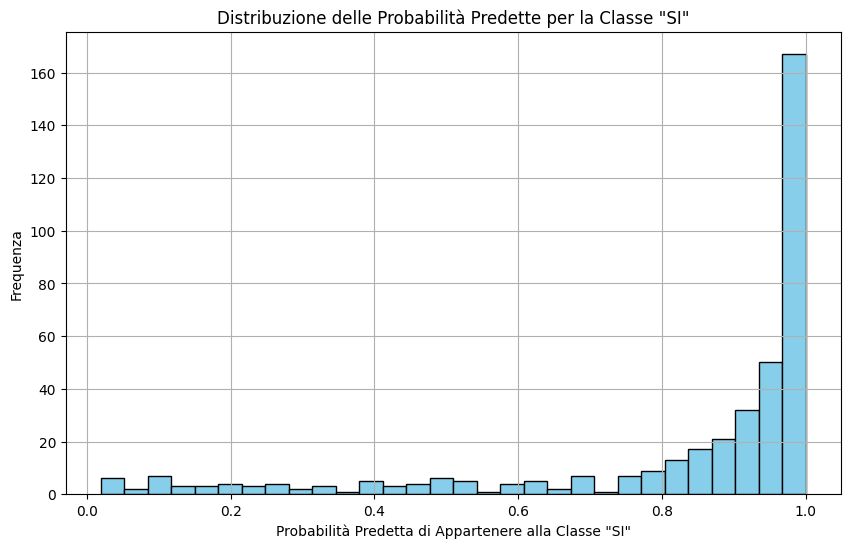

In [138]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

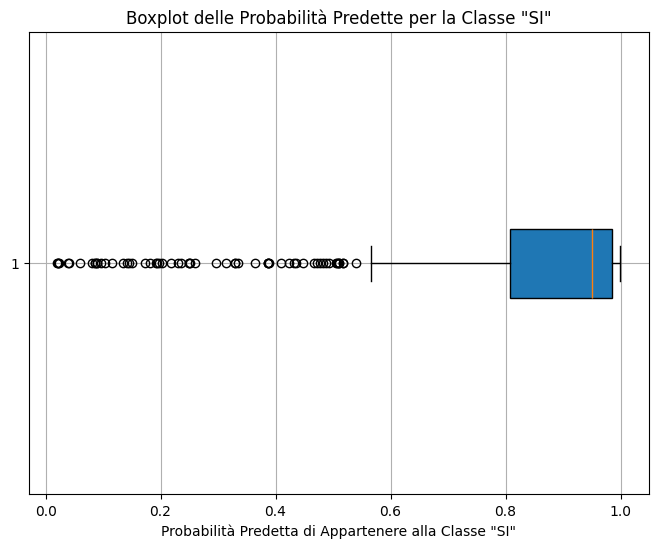

In [139]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()